In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from PIL import Image

### Area of interest

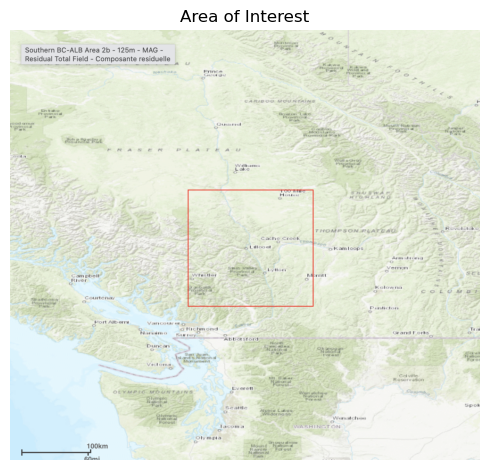

In [2]:
img = np.asarray(Image.open("area.png"))
imgplot = plt.imshow(img)
plt.axis("off")
plt.title("Area of Interest")
plt.tight_layout()
plt.show()

### Import data from .csv file

In [3]:
df = pd.read_csv(
    "data/gsc_s_bc_alb_2b.csv",
    header=None,               
    skiprows=9,               
    names=[
        "X",          
        "Y",         
        "TIME",       
        "MAGLEV",      
        "SRVMGLEV",   
        "MAGADJ",      
        "DIURNAL",    
        "MAGDIST",     
        "RALT",       
        "BALT",        
        "FLIGHT",      
        "MAGLEV_used",
        "LINE",       
        "LINETYPE",    
        "LINENAME",   
        "Extra"       
    ],
    sep=",",                  
    engine="python",
    skipinitialspace=True
)

print(df.shape)
df


(120726, 16)


,X,Y,TIME,MAGLEV,SRVMGLEV,MAGADJ,DIURNAL,MAGDIST,RALT,BALT,FLIGHT,MAGLEV_used,LINE,LINETYPE,LINENAME,Extra
0,-123.0197,51.2383,552.00,-9.97,57124.78,13.47,57939.4,12.5,1092.71,3306.00,16,f,11281,L,L11281,NaN
1,-123.0202,51.2383,552.17,-9.97,57124.71,13.47,57939.2,10.6,1092.71,3306.00,16,f,11281,L,L11281,NaN
2,-123.0207,51.2383,552.33,-10.01,57124.62,13.47,57939.1,8.7,1085.09,3306.00,16,f,11281,L,L11281,NaN
3,-123.0213,51.2383,552.50,-10.12,57124.52,13.47,57939.1,6.4,1085.09,3306.00,16,f,11281,L,L11281,NaN
4,-123.0218,51.2383,552.67,-10.26,57124.40,13.47,57939.2,4.5,1078.99,3306.00,16,f,11281,L,L11281,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120721,-121.9102,51.5277,2316.50,65.12,57538.93,5.39,57946.9,1020.3,1313.69,2389.14,27,f,11590,L,L11590,NaN
120722,-121.9107,51.5276,2316.67,64.18,57538.65,5.39,57946.9,1019.4,1313.69,2389.14,27,f,11590,L,L11590,NaN
120723,-121.9113,51.5275,2316.83,62.74,57538.30,5.39,57946.9,1018.2,1315.21,2387.10,27,f,11590,L,L11590,NaN
120724,-121.9117,51.5272,2317.00,61.87,57537.91,5.39,57946.9,1017.2,1312.16,2387.10,27,f,11590,L,L11590,NaN


In [4]:
# Remove the outlier of the graph (Value of 50000)
# df_outlier = df.sort_values(by='BALT', ascending=False)
# df_outlier.iloc[0:74]

df_new = df.loc[df['BALT']<3000]
df_new.sort_values(by='BALT', ascending=False).iloc[0:120]

df.sort_values(by='FLIGHT', ascending=False)

,X,Y,TIME,MAGLEV,SRVMGLEV,MAGADJ,DIURNAL,MAGDIST,RALT,BALT,FLIGHT,MAGLEV_used,LINE,LINETYPE,LINENAME,Extra
10960,-122.1397,51.0798,1009.50,185.40,57483.66,-77.74,57898.6,468.4,786.38,2478.99,100,t,11111,L,L11111,NaN
10961,-122.1390,51.0797,1009.67,185.36,57483.99,-77.74,57898.6,468.9,786.38,2478.99,100,t,11111,L,L11111,NaN
10962,-122.1383,51.0798,1009.83,185.92,57484.33,-77.74,57898.7,470.2,786.38,2478.99,100,t,11111,L,L11111,NaN
10963,-122.1377,51.0798,1010.00,186.11,57484.68,-77.74,57898.8,471.1,787.91,2481.03,100,t,11111,L,L11111,NaN
120436,-121.9365,51.4573,212.83,62.35,57525.65,-85.03,57886.7,910.8,50000.00,2472.86,100,f,11541,L,L11541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80164,-122.6566,51.4795,776.83,169.09,57610.94,20.72,57954.2,682.5,964.69,2421.81,9,t,11560,L,L11560,NaN
80165,-122.6560,51.4795,777.00,178.27,57617.22,20.72,57954.7,683.5,970.79,2425.90,9,t,11560,L,L11560,NaN
80166,-122.6553,51.4795,777.17,189.50,57623.61,20.71,57955.9,684.5,970.79,2425.90,9,t,11560,L,L11560,NaN
80167,-122.6547,51.4795,777.33,199.62,57630.08,20.71,57957.1,685.4,975.36,2425.90,9,t,11560,L,L11560,NaN


### Interpolate barometric altitude (BALT) and MAGLEV into a regular grid

In [5]:
from scipy.interpolate import griddata

# Define grid
xi = np.linspace(df_new["X"].min(), df_new["X"].max(), 300)
yi = np.linspace(df_new["Y"].min(), df_new["Y"].max(), 300)
X, Y = np.meshgrid(xi, yi)

Z = griddata((df_new["X"], df_new["Y"]), df_new["BALT"], (X, Y), method='linear')
Z2 = griddata((df_new["X"], df_new["Y"]), df_new["MAGLEV"], (X, Y), method='linear')

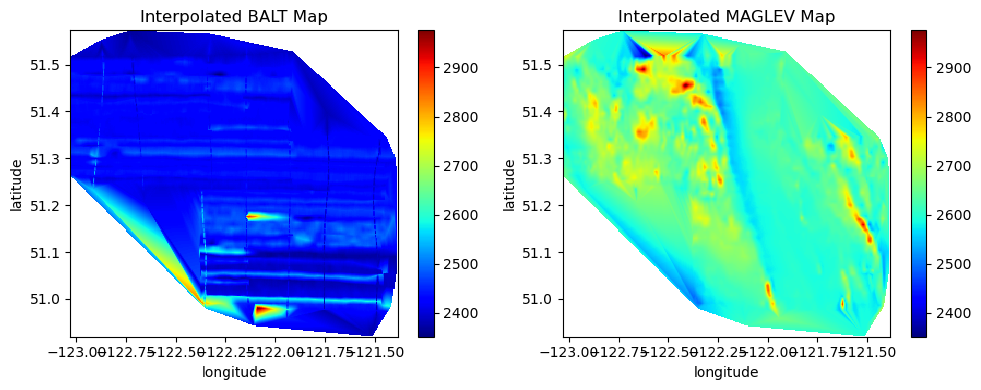

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

c = ax[0].pcolormesh(X, Y, Z, shading='auto',  cmap="jet")
fig.colorbar(c, ax=ax[0])
ax[0].set_title("Interpolated BALT Map")
ax[0].set_ylabel("latitude")
ax[0].set_xlabel("longitude")

c2 = ax[1].pcolormesh(X, Y, Z2, shading = 'auto',  cmap="jet")
ax[1].set_title("Interpolated MAGLEV Map")
ax[1].set_ylabel("latitude")
ax[1].set_xlabel("longitude")
fig.colorbar(c, ax=ax[1])

plt.tight_layout()

### Plot raw data for comparison with interpolations

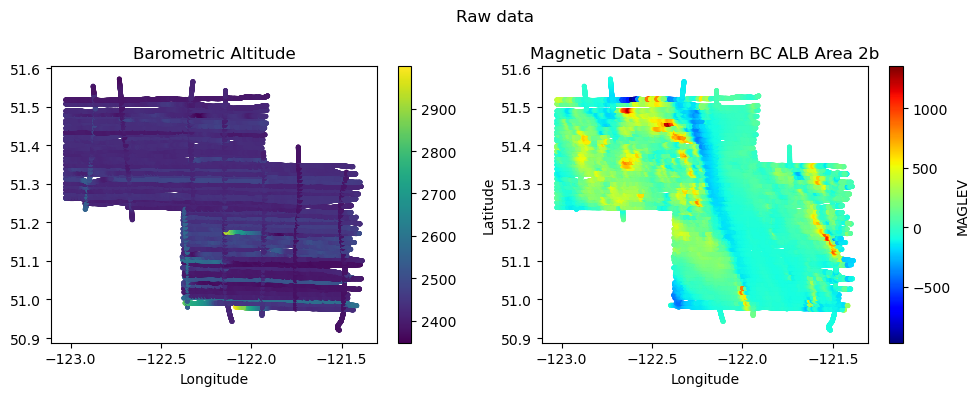

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

sc1 = ax[0].scatter(df_new["X"], df_new["Y"], c=df_new["BALT"], s=6)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel = ("Latitude")
fig.colorbar(sc1, ax = ax[0])
ax[0].set_title("Barometric Altitude")


sc2 = ax[1].scatter(df["X"], df["Y"], c=df["MAGLEV"], cmap="jet", s=6)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
# plt.contour([df["X"], df["Y"]], df["MAGLEV"])
fig.colorbar(sc2, ax=ax[1], label="MAGLEV")
ax[1].set_title("Magnetic Data - Southern BC ALB Area 2b")

fig.suptitle("Raw data")
plt.tight_layout()
plt.show()



### Slice the data at the latitude of 51.3

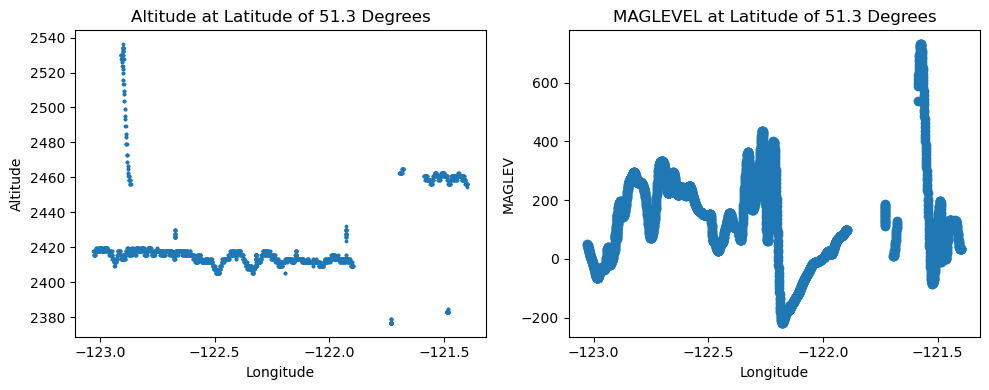

In [8]:
# filter the data at latitude of 51.3

filter_df = df_new[(df_new["Y"] > 51.295) & (df_new["Y"] < 51.305)]

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].scatter(filter_df["X"], filter_df["BALT"], s = 3)
ax[0].set_xticks([-123, -122.5, -122, -121.5])
ax[0].set_title("Altitude at Latitude of 51.3 Degrees")
ax[0].set_ylabel("Altitude")
ax[0].set_xlabel("Longitude")

ax[1].scatter(filter_df["X"], filter_df["MAGLEV"])
ax[1].set_xticks([-123, -122.5, -122, -121.5])
ax[1].set_title("MAGLEVEL at Latitude of 51.3 Degrees")
ax[1].set_ylabel("MAGLEV")
ax[1].set_xlabel("Longitude")

plt.tight_layout()
plt.show()

In [9]:
maximum_anomaly = np.max(np.abs(filter_df["MAGLEV"]))

std = 0.02 * maximum_anomaly * np.ones(len(filter_df))
# len(filter_df)